In [1]:
# import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the data
df = pd.read_csv(r'/content/songs.csv')
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [3]:
df.shape

(114000, 21)

We've got 114k tuples and 21 attributes.

In [4]:
df.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

These are the column names we'll be working with.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [6]:
#Let's check if there is any null values in the dataset
df.isnull().sum()

,0
Unnamed: 0,0
track_id,0
artists,1
album_name,1
track_name,1
popularity,0
duration_ms,0
explicit,0
danceability,0
energy,0


In [7]:
#let's remove those tuples
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(114000, 21)
(113999, 21)


In [8]:
#Let's use some of the columns which we won't be using in this work
df.drop(columns=['Unnamed: 0','track_id'], inplace=True)

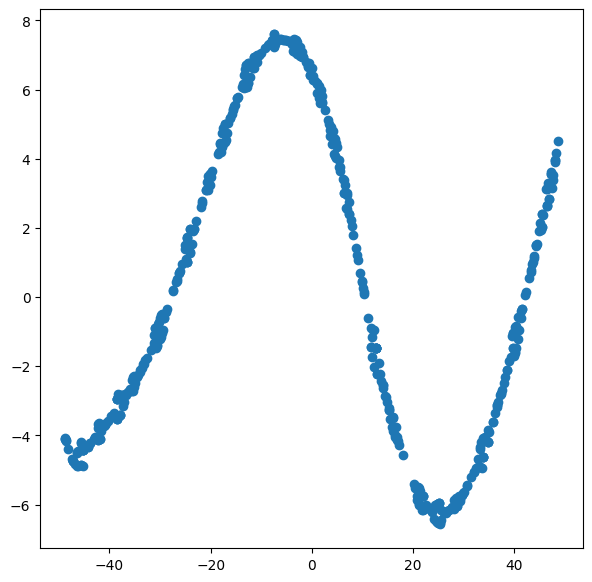

In [9]:
model = TSNE(n_components=2, random_state=42)
tsne_data = model.fit_transform(df[['popularity','duration_ms','danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness']].head(500))
plt.figure(figsize=(7,7))
plt.scatter(tsne_data[:,0], tsne_data[:,1])
plt.show()

* We can see there definately is some kind of pattern in the numerical attributes.
* We don't know what the above pattern might mean.

In [10]:
# Let's check if there is any duplicate in the dataset baed i
df.duplicated().sum()

577

In [11]:
# Let's check if there is any duplicate using track names in the dataset
print(df.duplicated(subset=['track_name']).sum())
print(df.shape)

40391
(113999, 19)


* We can see there are a lot of duplicated values in the dataset
* We need to deal with them by removing them
* We could have checked for entire tuples to be dupicated but it might have not been the most accurate since same song name means it's a same song so it is more appropriate to remove the duplicated songs by their name.
* In the meanwhile let's also arrange the songs in order of it's popularity.

In [12]:
# arranging the songs based on popularity
df = df.sort_values(by='popularity', ascending=False)

# removing duplicates
print(df.shape)
df.drop_duplicates(subset=['track_name'], keep='first' ,inplace=True)
print(df.shape)

(113999, 19)
(73608, 19)


We are now left with over 73k tuples.

In [13]:
# Let's separate categorical and numerical columns from the dataset
cols = df.dtypes == 'object'
obj_cols = cols[cols].index
print("Object Columns are : ",obj_cols)
cols = df.dtypes != 'object'
num_cols = cols[cols].index
print("Numerical Columns are : ",num_cols)

Object Columns are :  Index(['artists', 'album_name', 'track_name', 'track_genre'], dtype='object')
Numerical Columns are :  Index(['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')


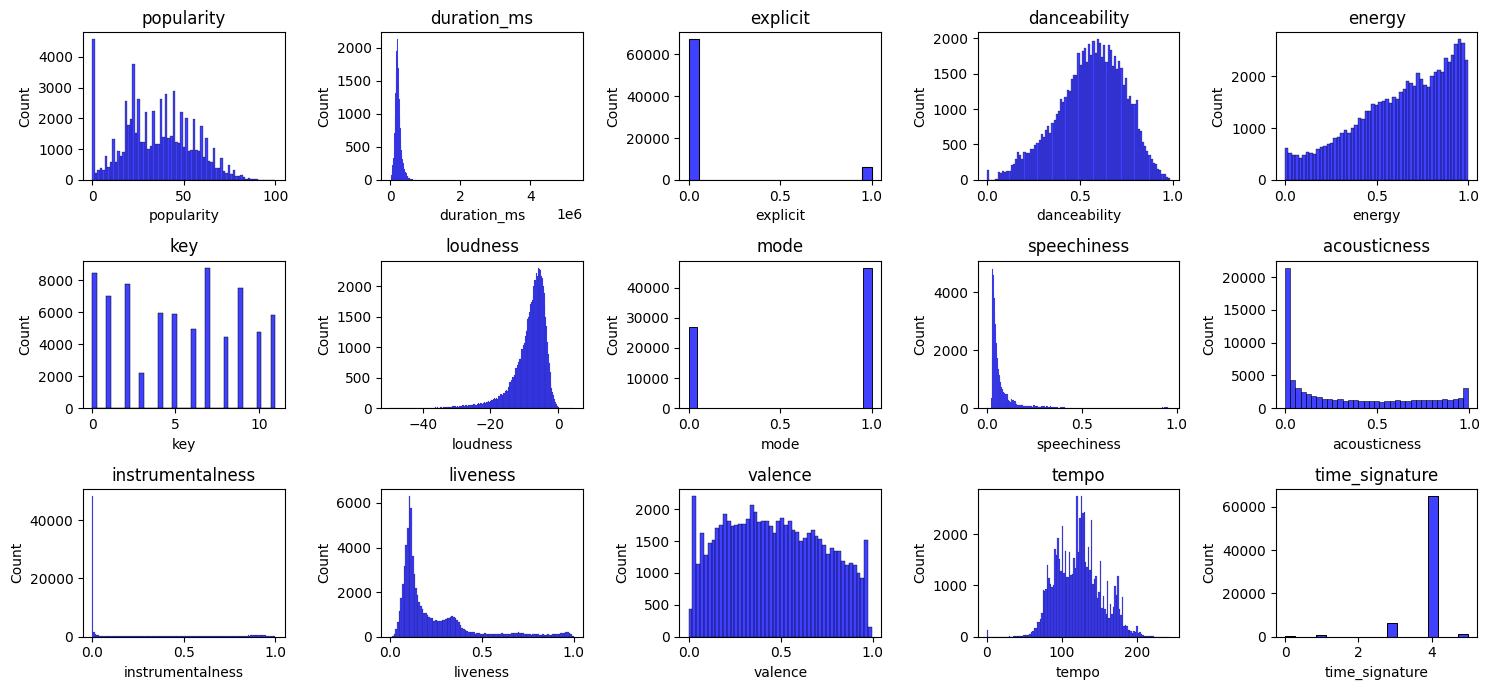

In [14]:
# Let's check the distribution of all the numerical columns
plt.figure(figsize=(15,7))
index = 0
for col in num_cols:
    index += 1
    plt.subplot(3, 5, index)
    sns.histplot(df[col], color='blue')
    plt.title(col)
    plt.tight_layout()
plt.show()

* None of the columns are normally distributed
* We can observe almost all the columns are skewed

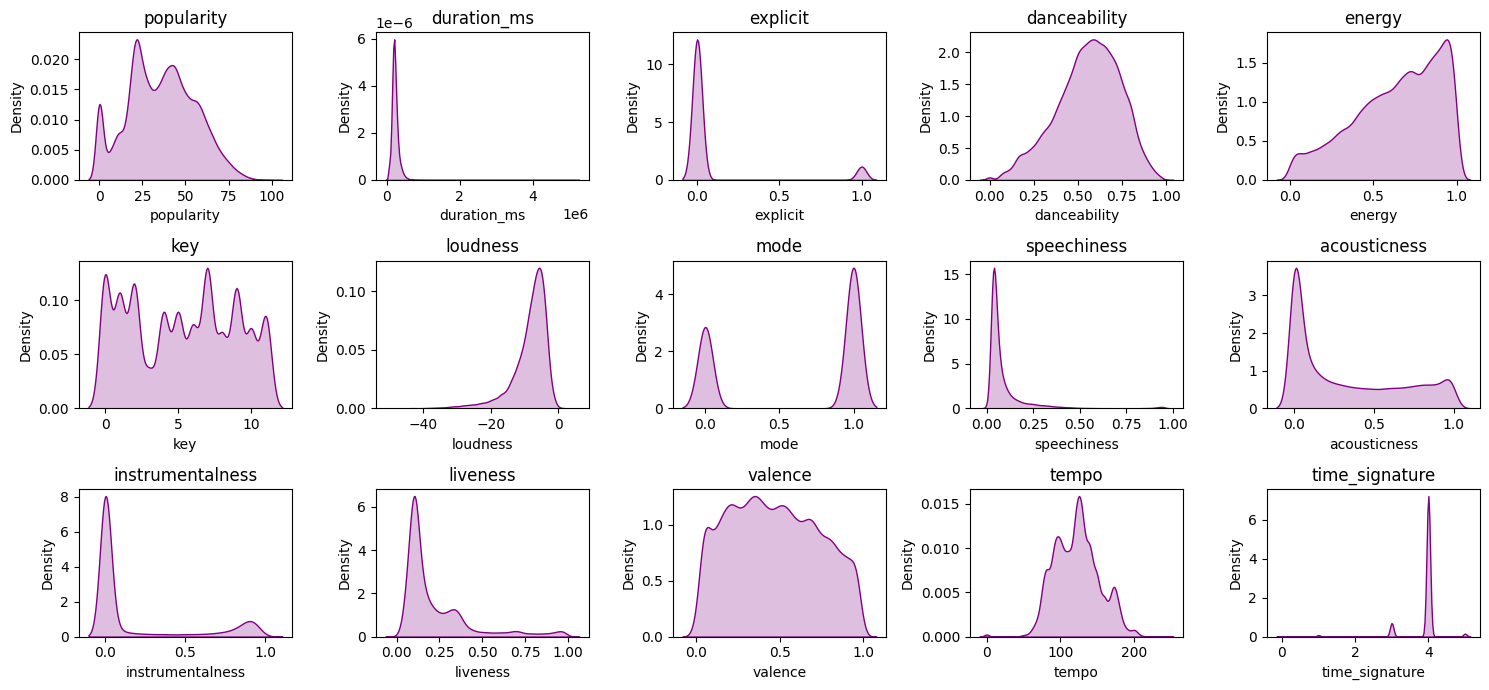

In [15]:
# Let's observe the above same thing with density plot
plt.figure(figsize=(15,7))
index = 0
for col in num_cols:
    index += 1
    plt.subplot(3, 5, index)
    sns.kdeplot(df[col], fill=True, color="purple")
    plt.title(col)
    plt.tight_layout()
plt.show()

* Many columns seems to be one tailed
* Many columns are unimodal, and only a few are bimodal.

In [16]:
# We will be working with only top 10,000 popular songs in this example because of the memory contraints

df = df.sort_values(by=['popularity'], ascending = False).head(10000)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
genre_matrix = cv.fit_transform(df['track_genre'])
genre_matrix

<10000x105 sparse matrix of type '<class 'numpy.int64'>'
	with 12314 stored elements in Compressed Sparse Row format>

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_features = scaler.fit_transform(df[['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']])

# num_features = scaler.fit_transform(df[['popularity', 'danceability']])

In [26]:
feature_matrix = np.hstack([genre_matrix.toarray(), num_features])
feature_matrix

array([[0.        , 0.        , 0.        , ..., 0.23991935, 0.53876781,
        0.8       ],
       [0.        , 0.        , 0.        , ..., 0.55443548, 0.52607942,
        0.8       ],
       [0.        , 0.        , 0.        , ..., 0.85685484, 0.51353484,
        0.8       ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.47278226, 0.30816199,
        0.8       ],
       [0.        , 0.        , 0.        , ..., 0.22681452, 0.51426212,
        0.8       ],
       [0.        , 0.        , 0.        , ..., 0.18245968, 0.5599576 ,
        0.6       ]])

* Above is the feature matrix featuring all the numerical columns along with all the genre column.

In [27]:
# Let's build a function that gives top 5 similar songs based on the cosine similarity matrix

from sklearn.metrics.pairwise import cosine_similarity
def recommend_songs(df, song_name, feature_matrix, similarity_threshold = 0.75):
    song_index = df[df['track_name'].str.lower() == song_name.lower()].index

    if song_index.empty:
        return -1

    song_index = song_index[0]

    cosine_sim = cosine_similarity(feature_matrix)

    similarity_scores = list(enumerate(cosine_sim[song_index]))

    similar_songs = [(i, score) for i, score in similarity_scores if score >= similarity_threshold]

    similar_songs = sorted(similar_songs, key = lambda x: x[1], reverse=True)[:5]

    recommendations = [(df.iloc[i]['track_name'], score) for i, score in similar_songs]

    return recommendations

In [28]:
song = "Hold On"

recommendations = recommend_songs(df, song_name=song, feature_matrix=feature_matrix)
# recommendations
if recommendations == -1:
    print(f"Given song : {song} not found in the dataset, Please try with different song")
else:
    print("Recommended Songs are: ")
    for song_name, score in recommendations:
        print(f"{song} : Score = {score:.2f}")

Recommended Songs are: 
Hold On : Score = 1.00
Hold On : Score = 0.98
Hold On : Score = 0.97
Hold On : Score = 0.96
Hold On : Score = 0.96


In [ ]:
num_cols

In [ ]:
df.head()

In [ ]:
df.columns